# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [OBV](#section3)


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import numpy as np
import warnings
import seaborn as sns



from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.integrate import quad


In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['Open_minus_Low'] = (data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)
data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)
data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']

In [6]:
# Add new columns with the given calculations
data['Prev_Close'] = data['Close/Last'].shift(1)
data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)
data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

In [7]:
# Calculate day change adjusted for opening gap
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']


# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()


# Create features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)
data['MA_200'] = data['Open'].rolling(window=200).mean()


# Create a crossover signal column
data['MA_Crossover_Signal_5_14'] = ((data['MA_5'] > data['MA_14']) & (data['MA_5'].shift(1) <= data['MA_5'].shift(1))).astype(int)
data['MA_Crossover_Signal_today_5'] = ((data['Close/Last'] > data['MA_14']) & (data['Close/Last'].shift(1) <= data['MA_5'].shift(1))).astype(int)


# Shift 'High' and 'Low' columns by 1
data['High_shift'] = data['High'].shift(1)
data['Low_shift'] = data['Low'].shift(1)

# Define the opening gap with the condition
def calculate_opening_gaps(row):
    if row['Open'] > row['High_shift']:
        return (row['Open'] - row['High_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    elif row['Open'] < row['Low_shift']:
        return (row['Open'] - row['Low_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    else:
        return np.nan

# Apply the calculation function to each row
data['opening_gaps_2'] = data.apply(calculate_opening_gaps, axis=1)

data.dropna(inplace=True)

END OF SETUP

# <a id="section4"></a> Opening Gaps and Intraday Volatility
[Back to Table of Contents](#table-of-contents)


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.093
Model:                             OLS   Adj. R-squared:                  0.087
Method:                  Least Squares   F-statistic:                     13.08
Date:                 Fri, 27 Dec 2024   Prob (F-statistic):           0.000407
Time:                         16:16:25   Log-Likelihood:                 531.68
No. Observations:                  151   AIC:                            -1059.
Df Residuals:                      149   BIC:                            -1053.
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0050      0.002    

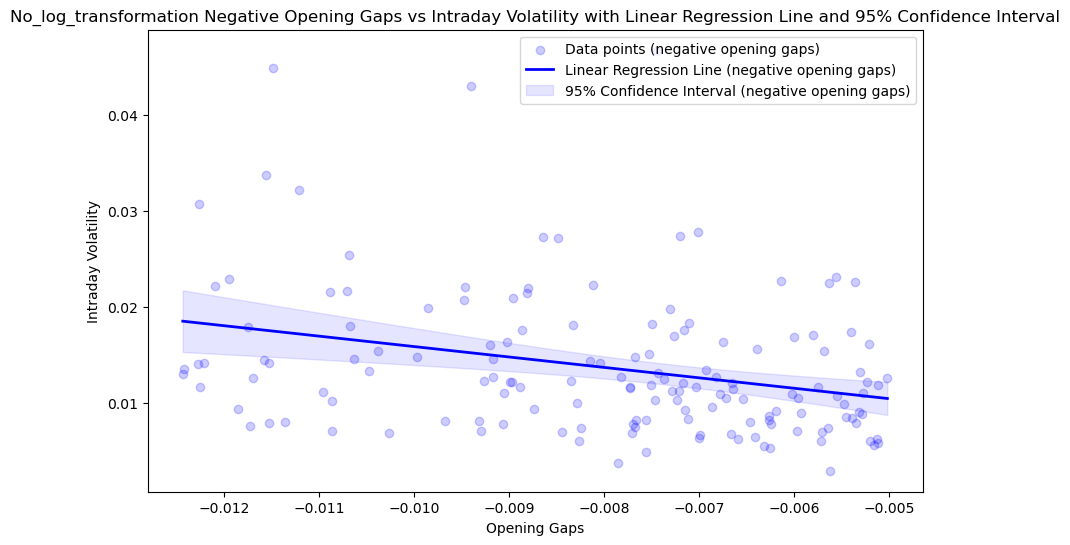

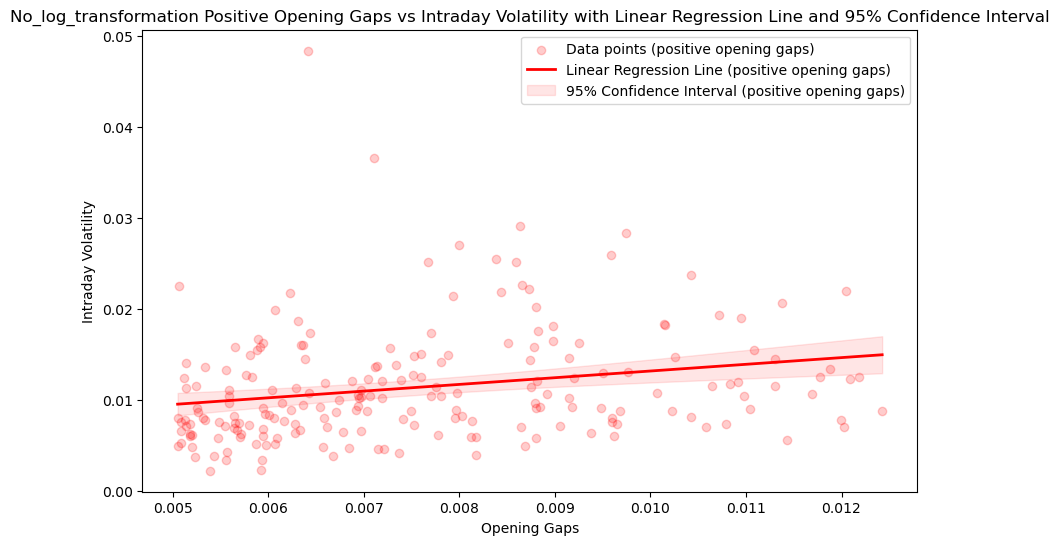


Addres the heteroskedasticity at least in part by doing a log transformation



In [20]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.0125) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.0125) & (data['Intraday_Volatility'] <= 0.05)].copy()

# First regression (below -0.005 and greater than -0.0125)
X_below = filtered_data_below['opening_gaps']
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['opening_gaps'])
sorted_opening_gaps_below = filtered_data_below['opening_gaps'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Second regression (greater than 0.005 and less than 0.0125)
X_above = filtered_data_above['opening_gaps']
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['opening_gaps'])
sorted_opening_gaps_above = filtered_data_above['opening_gaps'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['opening_gaps'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (negative opening gaps)')

# Plot the linear regression line for the first regression
plt.plot(sorted_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Linear Regression Line (negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (negative opening gaps)')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('No_log_transformation Negative Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['opening_gaps'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (positive opening gaps)')

# Plot the linear regression line for the second regression
plt.plot(sorted_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Linear Regression Line (positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (positive opening gaps)')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('No_log_transformation Positive Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''
Addres the heteroskedasticity at least in part by doing a log transformation
''')


In [19]:
# Perform the Breusch-Pagan test for the first regression (negative opening gaps)
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)

print('Breusch-Pagan Test for Negative Opening Gaps:')
print(f'Lagrange  multiplier statistic: {test_below[0]}')
print(f'p-value: {test_below[1]}')
print(f'F-statistic: {test_below[2]}')
print(f'F-test p-value: {test_below[3]}')

Breusch-Pagan Test for Negative Opening Gaps:
Lagrange multiplier statistic: 3.233026807759326
p-value: 0.07216718973749141
F-statistic: 3.260004478331123
F-test p-value: 0.07300770518695364


In [18]:
# Perform the Breusch-Pagan test for the second regression (positive opening gaps)
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)

print('Breusch-Pagan Test for Positive Opening Gaps:')
print(f'Lagrange BP multiplier statistic: {test_above[0]}')
print(f'p-value: {test_above[1]}')
print(f'F-statistic: {test_above[2]}')
print(f'F-test p-value: {test_above[3]}')

Breusch-Pagan Test for Positive Opening Gaps:
Lagrange multiplier statistic: 0.02726080730320235
p-value: 0.8688586053717626
F-statistic: 0.026999712251478
F-test p-value: 0.869645163164838


In [41]:
# Dictionary to store test results for different lags
lag_stats_above = {}

# Loop through lags from 1 to 10
for lag in range(1, 11):
    bg_test_above = smd.acorr_breusch_godfrey(model_above, nlags=lag)
    lag_stats_above[lag] = bg_test_above  # Store the test results

# Sort the lag statistics in descending order and get the top 3
sorted_lag_stats_above = sorted(lag_stats_above.items(), key=lambda item: item[1][0], reverse=True)[:3]

# Print the results
print('Top 3 Lags with Highest Lagrange Multiplier Statistics for Positive Opening Gaps:')
for lag, result in sorted_lag_stats_above:
    lm_statistic = result[0]
    p_value = result[1]
    f_statistic = result[2]
    f_test_p_value = result[3]
    print(f'Lag: {lag}')
    print(f'Lagrange multiplier statistic: {lm_statistic}')
    print(f'p-value: {p_value}')
    print(f'F-statistic: {f_statistic}')
    print(f'F-test p-value: {f_test_p_value}')
    print('---')

print('''
the godfrey test will use all the features and the lagged residuals (# of lagged time periods specified) in order to explain the residuals. Increasing the
# of accepted lags will spike the LAgrange multiplier essentially giving you an overfit model. The code above balances optimizing the p-value with the Lagrange
Multiplier.

When increasing the number of lagged values increases the p-value by "significant_rise" the loop stops

''')

Top 3 Lags with Highest Lagrange Multiplier Statistics for Positive Opening Gaps:
Lag: 10
Lagrange multiplier statistic: 22.606446842584536
p-value: 0.01229626458917147
F-statistic: 2.391387598939745
F-test p-value: 0.010713344506423876
---
Lag: 9
Lagrange multiplier statistic: 22.58891609552534
p-value: 0.007188625140952403
F-statistic: 2.6684674938072783
F-test p-value: 0.00608675193866355
---
Lag: 8
Lagrange multiplier statistic: 22.50903749416203
p-value: 0.004055225257967798
F-statistic: 3.005441854333413
F-test p-value: 0.003336574563943708
---

the godfrey test will use all the features and the lagged residuals (# of lagged time periods specified) in order to explain the residuals. Increasing the
# of accepted lags will spike the LAgrange multiplier essentially giving you an overfit model. The code above balances optimizing the p-value with the Lagrange
Multiplier.

When increasing the number of lagged values increases the p-value by "significant_rise" the loop stops




In [40]:
# Initialize variables
previous_p_value_above = float('inf')  # Set initial previous p-value to infinity
significant_rise = 0.02  # Define a threshold for significant rise in p-value

# List to store test results for different lags for positive opening gaps
lag_results_above = []

# Loop through lags until we see a significant rise in p-value
for lag in range(1, 21):  # Example: increase lags up to 20
    bg_test_above = smd.acorr_breusch_godfrey(model_above, nlags=lag)
    lag_results_above.append((lag, bg_test_above))  # Store the test results

    # Extract current p-value
    current_p_value_above = bg_test_above[1]

    # Check if p-value starts to rise significantly
    if current_p_value_above > previous_p_value_above + significant_rise:
        break

    # Update previous p-value
    previous_p_value_above = current_p_value_above

# Print the last 3 lag results for positive opening gaps
print('Results for the Last 3 Lags Tested for Positive Opening Gaps:')
for lag, bg_test in lag_results_above[-3:]:
    print(f'Lag: {lag}')
    print(f'Lagrange multiplier statistic: {bg_test[0]}')
    print(f'p-value: {bg_test[1]}')
    print(f'F-statistic: {bg_test[2]}')
    print(f'F-test p-value: {bg_test[3]}')
    print('---')

    
print('''
the godfrey test will use all the features and the lagged residuals (# of lagged time periods specified) in order to explain the residuals. Increasing the
# of accepted lags will spike the LAgrange multiplier essentially giving you an overfit model. The code above balances optimizing the p-value with the Lagrange
Multiplier.

When increasing the number of lagged values increases the p-value by "significant_rise" the loop stops

''')

Results for the Last 3 Lags Tested for Positive Opening Gaps:
Lag: 14
Lagrange multiplier statistic: 23.21308870531306
p-value: 0.0568895116240491
F-statistic: 1.7235083904804092
F-test p-value: 0.053758208501536765
---
Lag: 15
Lagrange multiplier statistic: 23.55820938275099
p-value: 0.07298578073877234
F-statistic: 1.6270035347624938
F-test p-value: 0.06984459219570906
---
Lag: 16
Lagrange multiplier statistic: 23.728797548944144
p-value: 0.0955974624681889
F-statistic: 1.5296622146055219
F-test p-value: 0.09285783298944617
---


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.093
Model:                             OLS   Adj. R-squared:                  0.087
Method:                  Least Squares   F-statistic:                     14.26
Date:                 Fri, 27 Dec 2024   Prob (F-statistic):           0.000230
Time:                         15:57:46   Log-Likelihood:                 531.71
No. Observations:                  151   AIC:                            -1059.
Df Residuals:                      149   BIC:                            -1053.
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

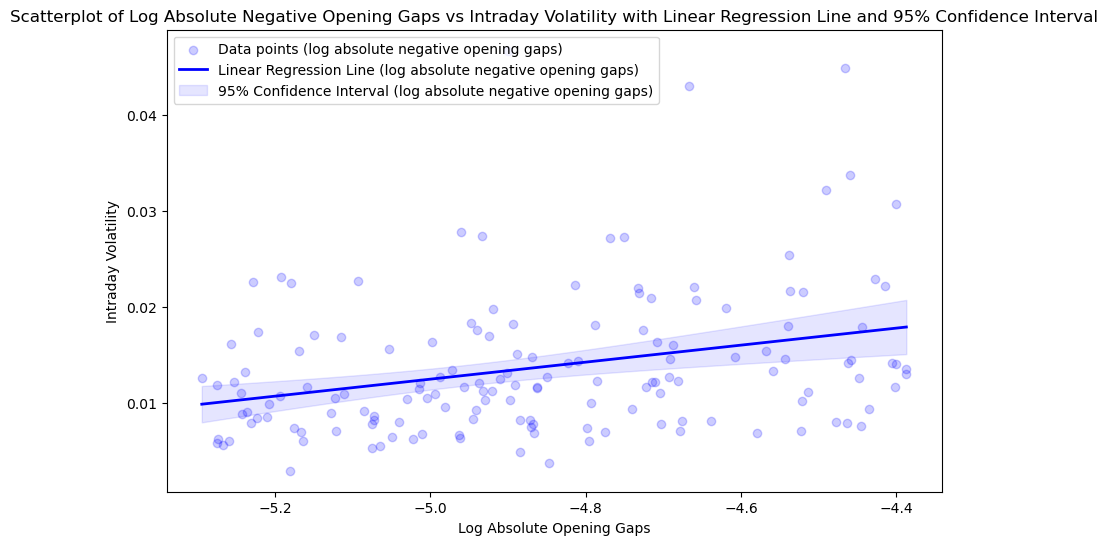

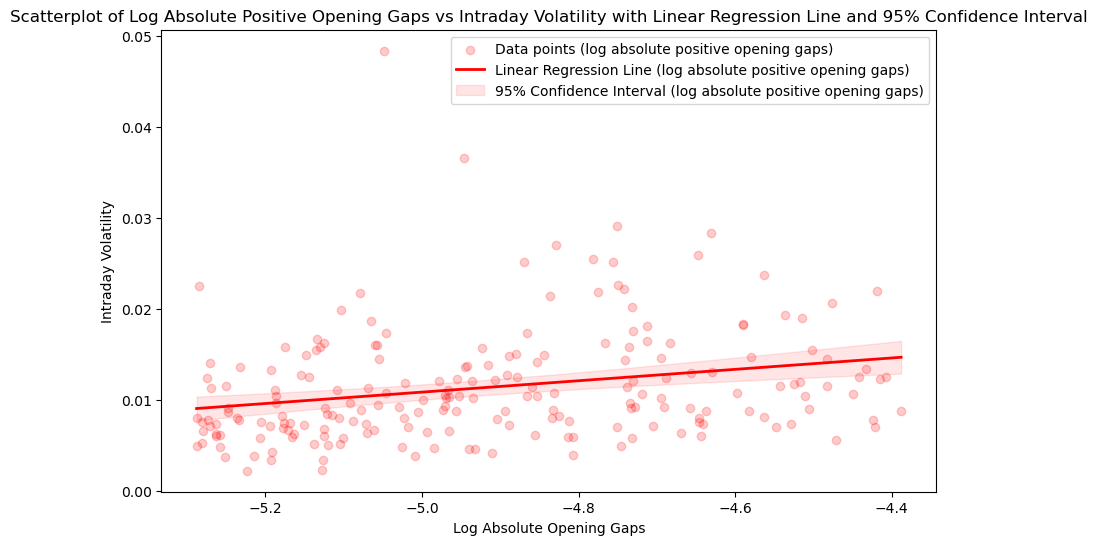

Negative Opening Gaps - Lagrange multiplier statistic: 3.301984416919044
Negative Opening Gaps - p-value: 0.06919624218194073
Positive Opening Gaps - Lagrange multiplier statistic: 0.1076173493093775
Positive Opening Gaps - p-value: 0.742873227858913
 

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.




In [9]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.0125) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.0125) & (data['Intraday_Volatility'] <= 0.05)].copy()

# Apply log transformation using the absolute values
filtered_data_below['log_abs_opening_gaps'] = np.log(np.abs(filtered_data_below['opening_gaps']))
filtered_data_above['log_abs_opening_gaps'] = np.log(filtered_data_above['opening_gaps'])

# First regression (below -0.005 and greater than -0.02)
X_below = filtered_data_below['log_abs_opening_gaps']
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_below = filtered_data_below['log_abs_opening_gaps'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Second regression (greater than 0.005 and less than 0.02)
X_above = filtered_data_above['log_abs_opening_gaps']
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_above = filtered_data_above['log_abs_opening_gaps'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['log_abs_opening_gaps'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (log absolute negative opening gaps)')

# Plot the linear regression line for the first regression
plt.plot(sorted_log_abs_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Linear Regression Line (log absolute negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_log_abs_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (log absolute negative opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Negative Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['log_abs_opening_gaps'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (log absolute positive opening gaps)')

# Plot the linear regression line for the second regression
plt.plot(sorted_log_abs_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Linear Regression Line (log absolute positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_log_abs_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (log absolute positive opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Positive Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print(''' 

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

''')


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.095
Model:                             OLS   Adj. R-squared:                  0.084
Method:                  Least Squares   F-statistic:                     9.332
Date:                 Fri, 27 Dec 2024   Prob (F-statistic):           0.000145
Time:                         15:57:47   Log-Likelihood:                 588.69
No. Observations:                  168   AIC:                            -1171.
Df Residuals:                      165   BIC:                            -1162.
Df Model:                            2                                         
Covariance Type:                   HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

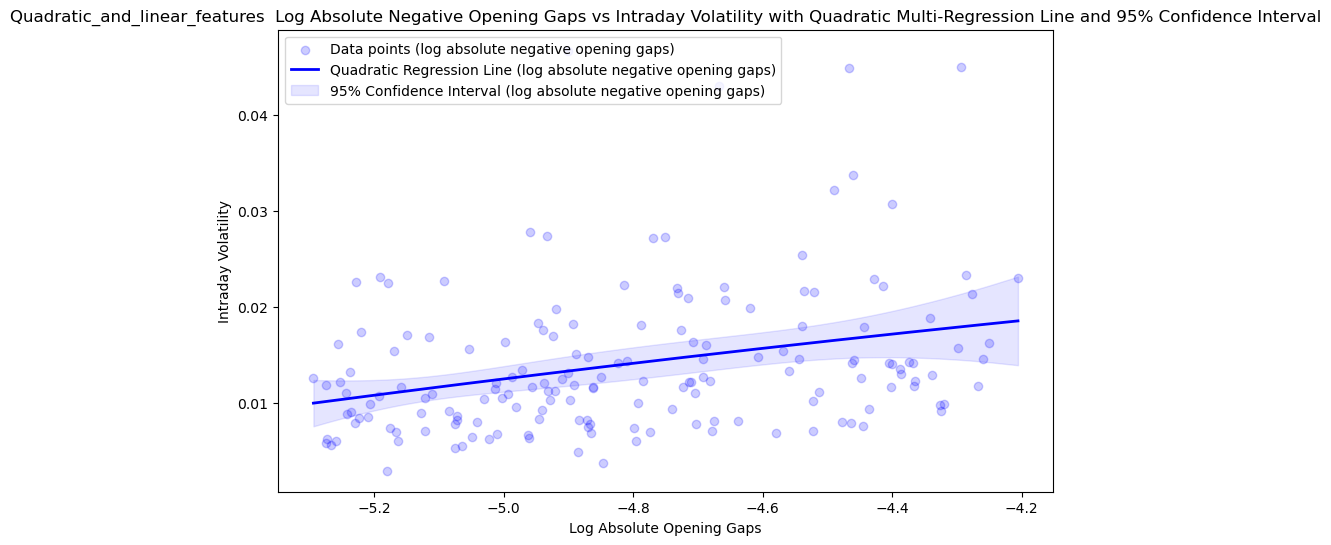

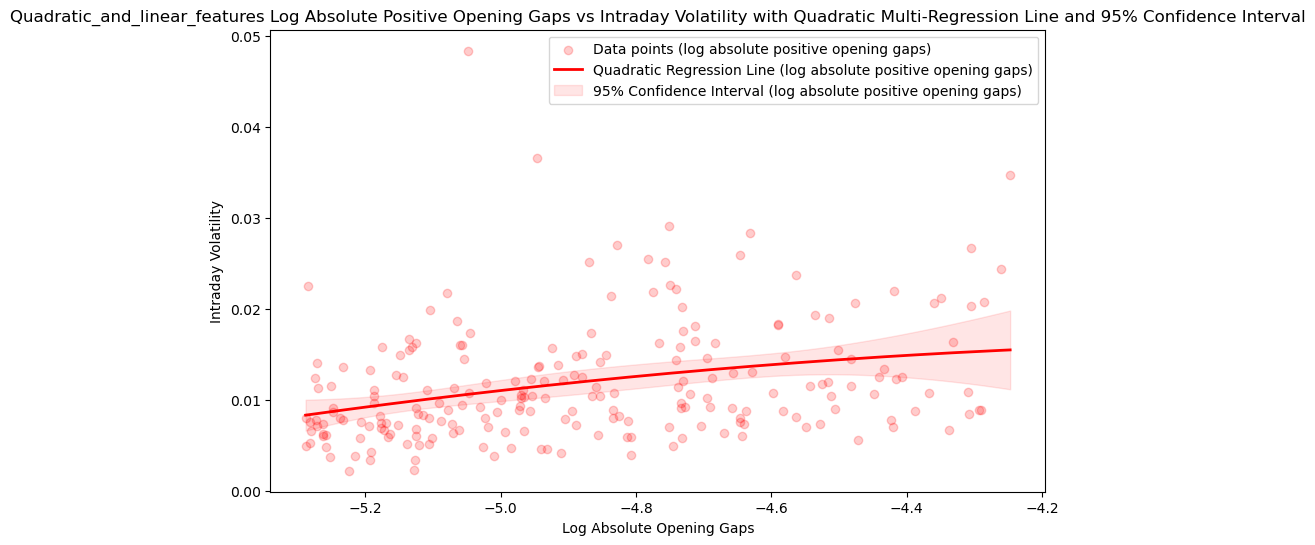

Negative Opening Gaps - Lagrange multiplier statistic: 3.159913775832286
Negative Opening Gaps - p-value: 0.2059839784120105
Positive Opening Gaps - Lagrange multiplier statistic: 0.9204295258163642
Positive Opening Gaps - p-value: 0.6311480837526684

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.



In [10]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.015) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.015) & (data['Intraday_Volatility'] <= 0.05)].copy()

# Apply log transformation using the absolute values
filtered_data_below['log_abs_opening_gaps'] = np.log(np.abs(filtered_data_below['opening_gaps']))
filtered_data_above['log_abs_opening_gaps'] = np.log(filtered_data_above['opening_gaps'])

# Add quadratic term for the first regression
filtered_data_below['log_abs_opening_gaps_squared'] = filtered_data_below['log_abs_opening_gaps'] ** 2

X_below = filtered_data_below[['log_abs_opening_gaps', 'log_abs_opening_gaps_squared']]
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_below = filtered_data_below['log_abs_opening_gaps'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Add quadratic term for the second regression
filtered_data_above['log_abs_opening_gaps_squared'] = filtered_data_above['log_abs_opening_gaps'] ** 2

X_above = filtered_data_above[['log_abs_opening_gaps', 'log_abs_opening_gaps_squared']]
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_above = filtered_data_above['log_abs_opening_gaps'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['log_abs_opening_gaps'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (log absolute negative opening gaps)')

# Plot the quadratic regression line for the first regression
plt.plot(sorted_log_abs_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Quadratic Regression Line (log absolute negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_log_abs_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (log absolute negative opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Quadratic_and_linear_features  Log Absolute Negative Opening Gaps vs Intraday Volatility with Quadratic Multi-Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['log_abs_opening_gaps'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (log absolute positive opening gaps)')

# Plot the quadratic regression line for the second regression
plt.plot(sorted_log_abs_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Quadratic Regression Line (log absolute positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_log_abs_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (log absolute positive opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Quadratic_and_linear_features Log Absolute Positive Opening Gaps vs Intraday Volatility with Quadratic Multi-Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print('''
Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.
''')


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.095
Model:                             OLS   Adj. R-squared:                  0.089
Method:                  Least Squares   F-statistic:                     17.40
Date:                 Fri, 27 Dec 2024   Prob (F-statistic):           4.87e-05
Time:                         15:57:47   Log-Likelihood:                 588.69
No. Observations:                  168   AIC:                            -1173.
Df Residuals:                      166   BIC:                            -1167.
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

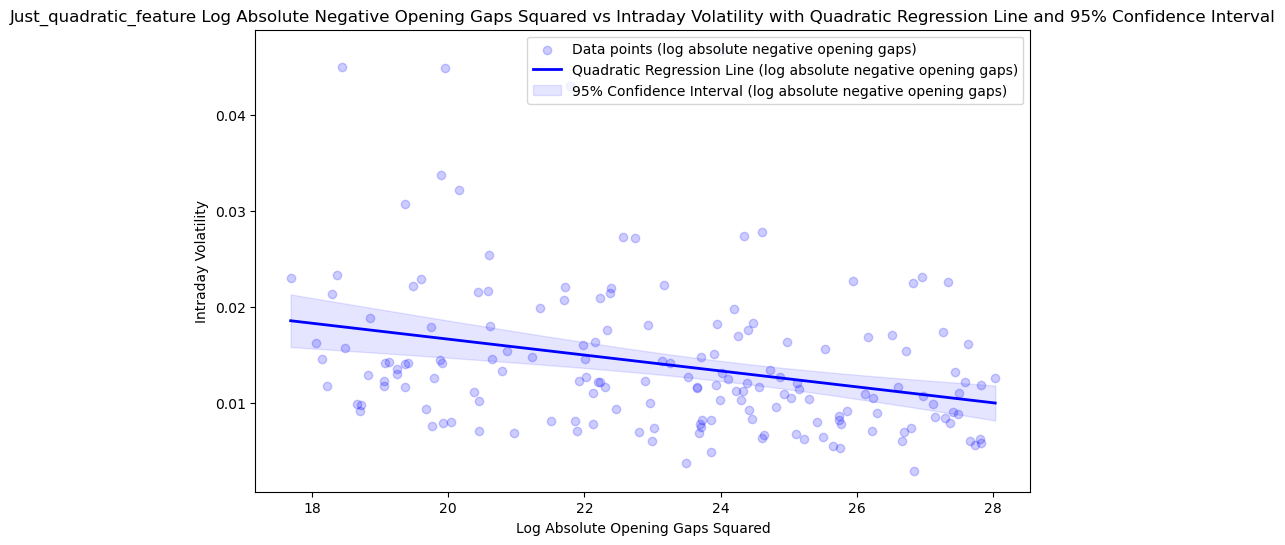

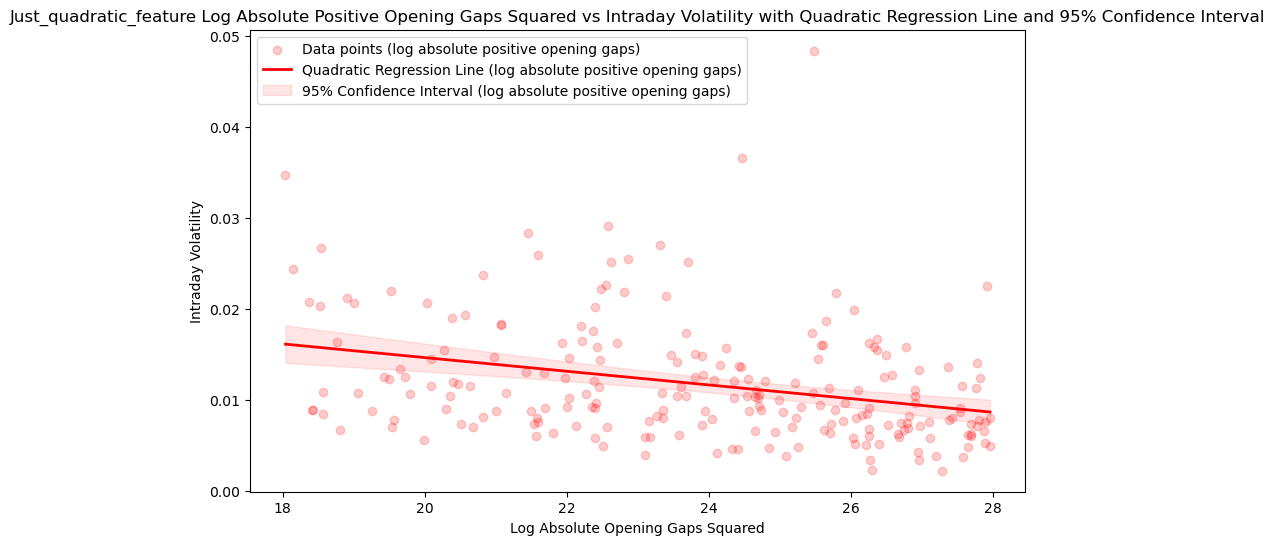

Negative Opening Gaps - Lagrange multiplier statistic: 3.0277566352522562
Negative Opening Gaps - p-value: 0.08185111494421374
Positive Opening Gaps - Lagrange multiplier statistic: 0.760997719491785
Positive Opening Gaps - p-value: 0.3830164691542187

the outperformacne of the qudaratic with linear feature scatterplot indicates that there is both a linear and quadratic relatinoship between the intraday volatiltiy 
and the opening gaps..




In [11]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.015) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.015) & (data['Intraday_Volatility'] <= 0.05)].copy()

# Apply log transformation using the absolute values
filtered_data_below['log_abs_opening_gaps'] = np.log(np.abs(filtered_data_below['opening_gaps']))
filtered_data_above['log_abs_opening_gaps'] = np.log(filtered_data_above['opening_gaps'])

# Add quadratic term for the first regression
filtered_data_below['log_abs_opening_gaps_squared'] = filtered_data_below['log_abs_opening_gaps'] ** 2

X_below = filtered_data_below[['log_abs_opening_gaps_squared']]
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['log_abs_opening_gaps_squared'])
sorted_log_abs_opening_gaps_below = filtered_data_below['log_abs_opening_gaps_squared'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Add quadratic term for the second regression
filtered_data_above['log_abs_opening_gaps_squared'] = filtered_data_above['log_abs_opening_gaps'] ** 2

X_above = filtered_data_above[['log_abs_opening_gaps_squared']]
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['log_abs_opening_gaps_squared'])
sorted_log_abs_opening_gaps_above = filtered_data_above['log_abs_opening_gaps_squared'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['log_abs_opening_gaps_squared'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (log absolute negative opening gaps)')

# Plot the quadratic regression line for the first regression
plt.plot(sorted_log_abs_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Quadratic Regression Line (log absolute negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_log_abs_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (log absolute negative opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps Squared')
plt.ylabel('Intraday Volatility')
plt.title('Just_quadratic_feature Log Absolute Negative Opening Gaps Squared vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['log_abs_opening_gaps_squared'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (log absolute positive opening gaps)')

# Plot the quadratic regression line for the second regression
plt.plot(sorted_log_abs_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Quadratic Regression Line (log absolute positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_log_abs_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (log absolute positive opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps Squared')
plt.ylabel('Intraday Volatility')
plt.title('Just_quadratic_feature Log Absolute Positive Opening Gaps Squared vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print('''
the outperformacne of the qudaratic with linear feature scatterplot indicates that there is both a linear and quadratic relatinoship between the intraday volatiltiy 
and the opening gaps..

''')
